In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt

### Graph of communications modelling

In [2]:
# Read the citation_relations.json file and generate a graph
with open('./data/citation_relations.json', 'r') as f:
    cite_data = json.load(f)

In [3]:
# Check if there are duplicate entries in the graph
node_set = set()
for paper_id in cite_data.keys():
    node_set.add(paper_id)
print(f"Duplicates count = {len(cite_data.keys()) - len(node_set)}")

Duplicates count = 0


In [4]:
# Create a list of nodes in the format expected by networkX
node_list = []
for paper_id in cite_data.keys():
    node_list.append({ 'id': paper_id })

In [5]:
link_list = []
for paper_id, paper_data in cite_data.items():
    for ref_paper_id in paper_data['references']:
        link_list.append({ 'source': paper_id, 'target': ref_paper_id })

In [6]:
graph_data = {
    'directed': True,
    'multigraph': False,
    'graph': {},
    'nodes': node_list,
    'links': link_list
}
comm_graph = nx.node_link_graph(graph_data)

### Detect clusters in the graph of communications

In [22]:
cluster_sizes = []
resolutions = [0.1, 0.5, 0.8, 1.0, 1.5, 2.0]
for res in resolutions:
    clusters = nx.community.louvain_communities(comm_graph, resolution=0.5)
    cluster_sizes.append([len(cluster) for cluster in clusters])

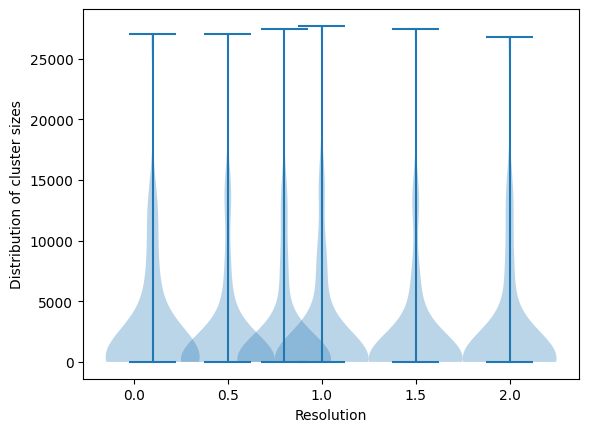

In [26]:
fig, ax = plt.subplots()
ax.violinplot(dataset=cluster_sizes, positions=resolutions)
ax.set_xlabel('Resolution')
ax.set_ylabel('Distribution of cluster sizes')
plt.show()

In [30]:
clusters = list(nx.community.girvan_newman(comm_graph))

KeyboardInterrupt: 

In [29]:
len(clusters)

TypeError: object of type 'generator' has no len()

In [28]:
# Plot distribution of cluster size
cluster_size = [len(cluster) for cluster in clusters]
fig, ax = plt.subplots()
ax.hist(cluster_size, bins=25, linewidth=1.5, edgecolor='black')
plt.show()

KeyboardInterrupt: 

In [12]:
for paper in papers:
    paper_data = json.loads(paper)
    if paper_data['paper_id'] in clusters[1]:
        print(paper_data["title"])

Quench dynamics of fermion-parity switches in a Josephson junction
Symbolic Versus Numerical Computation and Visualization of Parameter Regions for Multistationarity of Biological Networks
Large deviations of reaction fluxes
Intrinsic noise in systems with switching environments
Slow Manifolds for Multi-Time-Scale Stochastic Evolutionary Systems
Characterizing localized surface plasmons using electron energy-loss spectroscopy
Optimal transport for multifractal random measures. Applications
Measurement-feedback formalism meets information reservoirs
Realizations of kinetic differential equations
Shortcuts to adiabaticity: fast-forward approach
Large deviations for the branching Brownian motion in presence of selection or coalescence
Homogeneous dynamics in a vibrated granular monolayer
Multi-scale homogenization with bounded ratios and Anomalous Slow Diffusion
Work distribution in time-dependent logarithmic-harmonic potential: exact results and asymptotic analysis
Thermoelectrics in Cou

KeyboardInterrupt: 

In [10]:
papers[0]

'{"paper_id": "4650265", "title": "XGBoost: A Scalable Tree Boosting System", "abstract": ["tree boosting is a highly effective and widely used machine learning method .", "in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .", "we propose a novel sparsity - aware algorithm for sparse data and weighted quantile sketch for approximate tree learning .", "more importantly , we provide insights on cache access patterns , data compression and sharding to build a scalable tree boosting system .", "by combining these insights , xgboost scales beyond billions of examples using far fewer resources than existing systems ."], "section_names": ["introduction", "tree boosting in a nutshell", "regularized learning objective", "gradient tree boosting", "shrinkage and column subsampling", "basic exact greedy algorithm", "approximate algorithm", 

### Graph of similarity of communications modelling

In [9]:
with open('./data/papers.SSN.jsonl', 'r') as f:
    papers = f.readlines()

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Implement TF-IDF on the paper abstracts
abstracts = []
for paper in papers:
    paper_data = json.loads(paper)
    abstracts.append(" ".join(paper_data['abstract']))

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
abstract_matrix = vectorizer.fit_transform(abstracts)

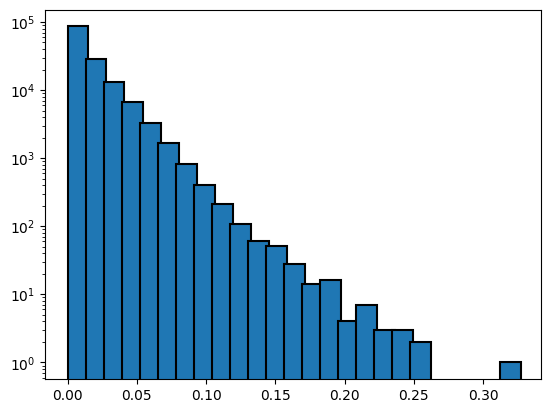

In [19]:
# Calculate the cosine similarity for the first 10000 papers
similarities = cosine_similarity(abstract_matrix[:10000], abstract_matrix)
similarities_arr = similarities.flatten()
similarities_arr = similarities_arr[similarities_arr < 0.99]

# Plot distribution of similarities
fig, ax = plt.subplots()
ax.hist(similarities_arr, bins=25, width=0.015, linewidth=1.5, edgecolor='black')
ax.semilogy()
plt.show()


In [18]:
# Create a list of links based on the cosine similarity in the format required by networkX
link_list = []
_MIN_SIMILARITY_THRESHOLD = 0.2
for source_node, source_data in enumerate(node_list):
    source_paper_id = source_data['id']
    similarities = cosine_similarity(abstract_matrix[source_node], abstract_matrix)
    similarities = similarities.flatten()
    for target_node, cos_sim in enumerate(similarities):
        if cos_sim > _MIN_SIMILARITY_THRESHOLD:
            target_paper_id = json.loads(papers[target_node])['paper_id']
            if target_paper_id != source_paper_id:
                link_list.append({ 'source': source_paper_id, 'target': target_paper_id, 'weight': cos_sim })

KeyboardInterrupt: 

In [38]:
# Create a networkX graph for the similarity graph
similarity_graph_data = {
    'directed': False,
    'multigraph': False,
    'graph': {},
    'nodes': node_list,
    'links': link_list
}
similarity_graph = nx.node_link_graph(graph_data)

'{"paper_id": "4650265", "title": "XGBoost: A Scalable Tree Boosting System", "abstract": ["tree boosting is a highly effective and widely used machine learning method .", "in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .", "we propose a novel sparsity - aware algorithm for sparse data and weighted quantile sketch for approximate tree learning .", "more importantly , we provide insights on cache access patterns , data compression and sharding to build a scalable tree boosting system .", "by combining these insights , xgboost scales beyond billions of examples using far fewer resources than existing systems ."], "section_names": ["introduction", "tree boosting in a nutshell", "regularized learning objective", "gradient tree boosting", "shrinkage and column subsampling", "basic exact greedy algorithm", "approximate algorithm", 